# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling, BinaryRandomSampling, IntegerRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover, SinglePointCrossover, PointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.mutation.rm import ChoiceRandomMutation
from pymoo.operators.mutation.gauss import GM, GaussianMutation
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.util import plotting
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from IPython.display import display
from time import time

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Verdana"

In [3]:
# more is better

def more_is_better(attr_min, attr_exp, attr_sup):
    if attr_sup >= attr_exp:
        return 1
    elif attr_sup >= attr_min:
        return (attr_sup - attr_min)/(attr_exp - attr_min)
    else:
        return -1


def less_is_better(attr_max, attr_exp, attr_sup):
    if attr_sup <= attr_exp:
        return 1
    elif attr_sup <= attr_max:
        return (attr_max - attr_sup)/(attr_max - attr_exp)
    else:
        return -1


def supplier_satisfaction(price_min, price_exp, price_buy):
    if price_buy >= price_exp:
        return 1
    elif price_buy >= price_min:
        return (price_buy - price_min)/(price_exp - price_min)
    else:
        return -1


def filter_dominated(X, F):
    f1 = np.copy(F[:, 0])
    f2 = np.copy(F[:, 1])
    n = len(f1)
    idx_drop = []

    for i in range(n):
        for j in range(n):
            if f1[j] > f1[i] and f2[j] > f2[i]:
                idx_drop.append(j)

    idx_drop = np.unique(np.array(idx_drop))
    # print(idx_drop)
    new_F = np.copy(F)
    new_F = np.delete(new_F, idx_drop, axis=0)
    new_X = np.copy(X)
    new_X = np.delete(new_X, idx_drop, axis=0)

    return new_X, new_F



In [4]:
# buyer df

cpu_min = np.array([1.7, 1.5, 1.7, 1.6, 1.6, 1.6, 1.6, 1.5, 1.5, 1.6])
cpu_exp = np.array([2, 2, 2, 2.2, 2.2, 2.2, 2.2, 1.8, 1.8, 1.8])
cpu_w = np.array([0.3, 0.3, 0.3, 0.6, 0.6, 0.3, 0.1, 0.1, 0.1, 0.6])
mem_min = np.array([0.5, 1, 0.5, 1, 1, 1, 1, 0.5, 1, 0.5])
mem_exp = np.array([1, 2, 1, 1, 2, 1, 2, 1, 1, 2])
mem_w = np.array([0.1, 0.1, 0.1, 0.3, 0.3, 0.1, 0.3, 0.3, 0.3, 0.3])
hd_min = np.array([60, 80, 80, 80, 80, 60, 80, 60, 60, 60])
hd_exp = np.array([100, 100, 120, 120, 100, 100, 100, 100, 100, 100])
hd_w = np.array([0.6, 0.6, 0.6, 0.1, 0.1, 0.6, 0.6, 0.6, 0.6, 0.1])
config_w = np.array([0.2, 0.2, 0.6, 0.5, 0.2, 0.2, 0.1, 0.4, 0.5, 0.5])
price_max_b = np.array([23, 22, 22, 21, 23, 21, 21, 21, 23, 23])
price_exp_b = np.array([19, 20, 20, 19, 19, 20, 20, 18, 18, 19])
price_w = np.array([0.3, 0.3, 0.3, 0.3, 0.1, 0.4, 0.5, 0.5, 0.1, 0.2])
delivery_time_max = np.array([4, 4, 5, 5, 4, 5, 4, 5, 4, 5])
delivery_time_exp = np.array([2, 3, 2, 2, 2, 3, 2, 3, 2, 2])
delivery_time_w = np.array([0.5, 0.5, 0.1, 0.2, 0.7, 0.4, 0.4, 0.1, 0.4, 0.3])
quantity_b = np.array([60, 20, 20, 90, 90, 50, 90, 90, 90, 90])

df1 = pd.DataFrame(list(zip(cpu_min, 
                            cpu_exp,
                            cpu_w,
                            mem_min,
                            mem_exp,
                            mem_w,
                            hd_min,
                            hd_exp,
                            hd_w,
                            config_w,
                            price_max_b,
                            price_exp_b,
                            price_w,
                            delivery_time_max,
                            delivery_time_exp,
                            delivery_time_w,
                            quantity_b
                           )
                       ),
                   columns=["cpu_min", "cpu_exp", "cpu_w",
                            "mem_min", "mem_exp", "mem_w",
                            "hd_min", "hd_exp", "hd_w",
                            "config_w",
                            "price_max", "price_exp", "price_w",
                            "delivery_time_max", "delivery_time_exp", "delivery_time_w",
                            "quantity_b"
                           ]
                  )
df1


cpu_min  cpu_exp  cpu_w  mem_min  mem_exp  mem_w  hd_min  hd_exp  hd_w  \
0      1.7      2.0    0.3      0.5        1    0.1      60     100   0.6   
1      1.5      2.0    0.3      1.0        2    0.1      80     100   0.6   
2      1.7      2.0    0.3      0.5        1    0.1      80     120   0.6   
3      1.6      2.2    0.6      1.0        1    0.3      80     120   0.1   
4      1.6      2.2    0.6      1.0        2    0.3      80     100   0.1   
5      1.6      2.2    0.3      1.0        1    0.1      60     100   0.6   
6      1.6      2.2    0.1      1.0        2    0.3      80     100   0.6   
7      1.5      1.8    0.1      0.5        1    0.3      60     100   0.6   
8      1.5      1.8    0.1      1.0        1    0.3      60     100   0.6   
9      1.6      1.8    0.6      0.5        2    0.3      60     100   0.1   

   config_w  price_max  price_exp  price_w  delivery_time_max  \
0       0.2         23         19      0.3                  4   
1       0.2         22         20      0.3                  4   
2       0.6         22         20      0.3                  5   
3       0.5         21         19      0.3                  5   
4       0.2         23         19      0.1                  4   
5       0.2         21         20      0.4                  5   
6       0.1         21         20      0.5                  4   
7       0.4         21         18      0.5                  5   
8       0.5         23         18      0.1                  4   
9       0.5         23         19      0.2                  5   

   delivery_time_exp  delivery_time_w  quantity_b  
0                  2              0.5          60  
1                  3              0.5          20  
2                  2              0.1          20  
3                  2              0.2          90  
4                  2              0.7          90  
5                  3              0.4          50  
6                  2              0.4          90  
7                  3              0.1          90  
8                  2              0.4          90  
9                  2              0.3          90

In [5]:
# supplier df

cpu = np.array([2, 1.7, 2, 1.8, 2.2, 1.6, 1.8, 1.5, 1.8, 2.2])
mem = np.array([0.5, 0.5, 2, 2, 1, 2, 1, 0.5, 1, 0.5])
hd = np.array([60, 80, 120, 100, 120, 120, 100, 80, 80, 120])
price_min_s = np.array([17, 17, 19, 18, 18, 17, 19, 18, 19, 19])
price_exp_s = np.array([20, 21, 20, 22, 23, 20, 22, 22, 22, 21])
delivery_time = np.array([4, 2, 4, 4, 3, 2, 3, 4, 3, 5])
quantity_s = np.array([30, 50, 100, 80, 100, 100, 30, 50, 80, 30])


df2 = pd.DataFrame(list(zip(cpu, 
                            mem,
                            hd,
                            price_min_s,
                            price_exp_s,
                            delivery_time,
                            quantity_s
                           )
                       ),
                   columns=["cpu",
                            "mem",
                            "hd",
                            "price_min", "price_exp",
                            "delivery_time",
                            "quantity_s"
                           ]
                  )
df2



cpu  mem   hd  price_min  price_exp  delivery_time  quantity_s
0  2.0  0.5   60         17         20              4          30
1  1.7  0.5   80         17         21              2          50
2  2.0  2.0  120         19         20              4         100
3  1.8  2.0  100         18         22              4          80
4  2.2  1.0  120         18         23              3         100
5  1.6  2.0  120         17         20              2         100
6  1.8  1.0  100         19         22              3          30
7  1.5  0.5   80         18         22              4          50
8  1.8  1.0   80         19         22              3          80
9  2.2  0.5  120         19         21              5          30

In [6]:
index_i = []
index_j = []
cpu_sat = []
mem_sat = []
hd_sat = []
price_sat_b = []
price_sat_s = []
delivery_time_sat = []

for i in range(len(cpu_min)):
    for j in range(len(cpu)):
        index_i.append(i)
        index_j.append(j)
        cpu_sat.append(more_is_better(cpu_min[i], cpu_exp[i], cpu[j]))
        mem_sat.append(more_is_better(mem_min[i], mem_exp[i], mem[j]))
        hd_sat.append(more_is_better(hd_min[i], hd_exp[i], hd[j]))
        price_sat_b.append(less_is_better(price_max_b[i], price_exp_b[i], price_exp_s[j]))
        price_sat_s.append(supplier_satisfaction(price_min_s[j], price_exp_s[j], price_exp_b[i]))
        delivery_time_sat.append(less_is_better(delivery_time_max[i], delivery_time_exp[i], delivery_time[j]))
        
index_i = np.array(index_i)
index_j = np.array(index_j)
cpu_sat = np.array(cpu_sat)
mem_sat = np.array(mem_sat)
hd_sat = np.array(hd_sat)
price_sat_b = np.array(price_sat_b)
price_sat_s = np.array(price_sat_s)
delivery_time_sat = np.array(delivery_time_sat)

In [7]:
display(index_i)
display(index_j)
display(price_sat_b)
display(price_sat_s)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([ 0.75      ,  0.5       ,  0.75      ,  0.25      ,  0.        ,
        0.75      ,  0.25      ,  0.25      ,  0.25      ,  0.5       ,
        1.        ,  0.5       ,  1.        ,  0.        , -1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.5       ,
        1.        ,  0.5       ,  1.        ,  0.        , -1.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.5       ,
        0.5       ,  0.        ,  0.5       , -1.        , -1.        ,
        0.5       , -1.        , -1.        , -1.        ,  0.        ,
        0.75      ,  0.5       ,  0.75      ,  0.25      ,  0.        ,
        0.75      ,  0.25      ,  0.25      ,  0.25      ,  0.5       ,
        1.        ,  0.        ,  1.        , -1.        , -1.        ,
        1.        , -1.        , -1.        , -1.        ,  0.        ,
        1.        ,  0.        ,  1.        , -1.        , -1.        ,
        1.        , -1.        , -1.        , -1.        ,  0.  

array([ 0.66666667,  0.5       ,  0.        ,  0.25      ,  0.2       ,
        0.66666667,  0.        ,  0.25      ,  0.        ,  0.        ,
        1.        ,  0.75      ,  1.        ,  0.5       ,  0.4       ,
        1.        ,  0.33333333,  0.5       ,  0.33333333,  0.5       ,
        1.        ,  0.75      ,  1.        ,  0.5       ,  0.4       ,
        1.        ,  0.33333333,  0.5       ,  0.33333333,  0.5       ,
        0.66666667,  0.5       ,  0.        ,  0.25      ,  0.2       ,
        0.66666667,  0.        ,  0.25      ,  0.        ,  0.        ,
        0.66666667,  0.5       ,  0.        ,  0.25      ,  0.2       ,
        0.66666667,  0.        ,  0.25      ,  0.        ,  0.        ,
        1.        ,  0.75      ,  1.        ,  0.5       ,  0.4       ,
        1.        ,  0.33333333,  0.5       ,  0.33333333,  0.5       ,
        1.        ,  0.75      ,  1.        ,  0.5       ,  0.4       ,
        1.        ,  0.33333333,  0.5       ,  0.33333333,  0.5 

In [8]:
# finding buyer satisfaction

cpu_w = np.repeat(cpu_w, len(cpu_min))
mem_w = np.repeat(mem_w, len(mem_min))
hd_w = np.repeat(hd_w, len(hd_min))
config_w = np.repeat(config_w, len(cpu_min))
price_w = np.repeat(price_w, len(price_max_b))
delivery_time_w = np.repeat(delivery_time_w, len(delivery_time_max))


cpu_sat = cpu_w * cpu_sat
mem_sat = mem_w * mem_sat
hd_sat = hd_w * hd_sat
config_sat = config_w * np.sum([cpu_sat, mem_sat, hd_sat], axis=0)
price_sat_b = price_w * price_sat_b
delivery_time_sat = delivery_time_w * delivery_time_sat

# buyer_sat
buyer_sat = np.sum([config_sat, price_sat_b, delivery_time_sat], axis=0)

In [9]:
# for objective function

quantity_b = np.repeat(quantity_b, len(quantity_b))
quantity_s = np.repeat(quantity_s, len(quantity_s))

quantity = np.minimum(quantity_b, quantity_s)
total_buyer_sat = buyer_sat * quantity
total_supplier_sat = price_sat_s * quantity

In [10]:
total_buyer_sat

array([ 8.55000000e+00,  2.13000000e+01,  1.27500000e+01,  7.05000000e+00,
        1.35000000e+01,  2.41500000e+01,  1.45500000e+01,  2.25000000e+00,
        1.27500000e+01, -5.10000000e+00,  4.40000000e+00,  1.30800000e+01,
        1.00000000e+01,  3.52000000e+00,  7.60000000e+00,  1.90400000e+01,
        1.31200000e+01, -4.00000000e-01,  1.07200000e+01, -3.80000000e+00,
        3.06666667e+00,  5.00000000e+00,  1.86666667e+01,  6.66666667e+00,
        7.33333333e+00,  1.28000000e+01,  7.33333333e+00, -2.93333333e+00,
        3.73333333e+00,  1.38000000e+01,  1.73333333e+01,  8.00000000e+00,
        4.93333333e+01,  3.33333333e+00,  2.66666667e+01,  4.40000000e+01,
        8.66666667e+00, -5.46666667e+01,  6.66666667e+00,  1.60000000e+01,
        6.75000000e+00,  6.39000000e+01,  2.11500000e+01,  1.30500000e+01,
        4.41000000e+01,  7.69500000e+01,  3.91500000e+01, -1.39500000e+01,
        3.73500000e+01, -5.13000000e+01,  3.10000000e+01,  2.25000000e+01,
        3.90000000e+01, -

# Evolutionary Multiobjective Optimization(EMO)

In [11]:
class newProblem(Problem):
    def __init__(self, m, v):
        super().__init__(n_var=100,
                        n_obj=2,
                        n_constr=0,
                        xl=np.array([0 for _ in range(100)]),
                        xu=np.array([1 for _ in range(100)]))
        self.m = m
        self.v = v
    def _evaluate(self, x, out, *args, **kwargs):
        f1 = -np.dot(np.array(x), self.m)
        f2 = -np.dot(np.array(x), self.v)
#         g1 = np.array(x)- 1
#         g2 = np.sum(len(np.array(x)))-1
    
        out["F"] = np.column_stack([f1, f2])
#         out["G"] = g1

## first iteration - two point crossover and gaussian mutation

In [12]:
problem = newProblem(total_buyer_sat, total_supplier_sat)
algorithm = NSGA2(pop_size=500,
                  n_offsprings=200,
                  sampling=IntegerRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=GaussianMutation(),
                  repair=RoundingRepair(),
                  eliminate_duplicates=True,
                )

termination = get_termination("n_gen", 250)
start = time()
res = minimize(problem,
               algorithm,
               # termination,
               seed=42,
               save_history=True,
               verbose=True
              )
print(f"Running time: {time()-start:.4f} seconds")
X = res.X
F = res.F


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      3 |             - |             -
     2 |      700 |      4 |  0.1801363194 |         ideal
     3 |      900 |      5 |  0.0789014909 |             f
     4 |     1100 |      7 |  0.0744898010 |             f
     5 |     1300 |      7 |  0.1659909987 |         ideal
     6 |     1500 |      6 |  0.3283729831 |         ideal
     7 |     1700 |      6 |  0.2164279435 |         ideal
     8 |     1900 |      3 |  0.1875564518 |         ideal
     9 |     2100 |      7 |  0.1431790551 |         ideal
    10 |     2300 |     10 |  0.0779797980 |         ideal
    11 |     2500 |      7 |  0.0368349250 |         ideal
    12 |     2700 |     10 |  0.0878004661 |         ideal
    13 |     2900 |     12

In [13]:
X[11]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [14]:
print(X.shape)
print(F.shape)

(278, 100)
(278, 2)


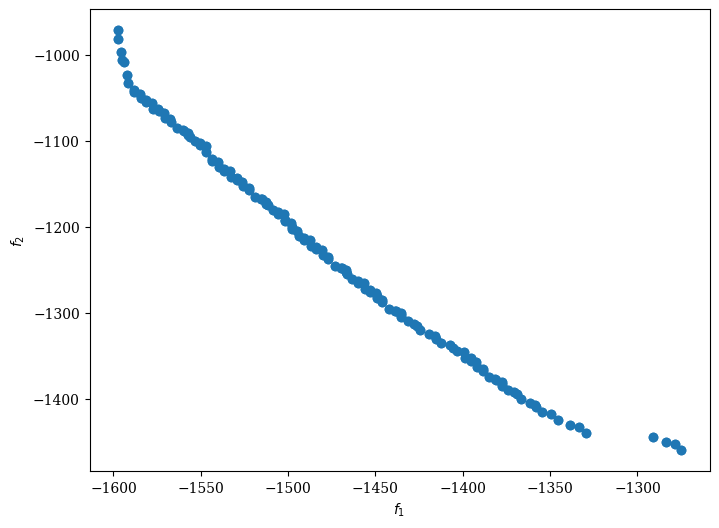

In [15]:
Scatter().add(res.F).show()

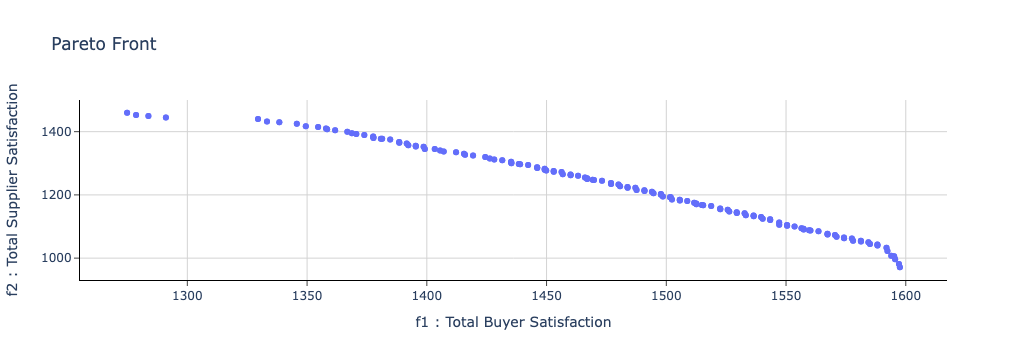

In [16]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*F[:,0], y=-1*F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

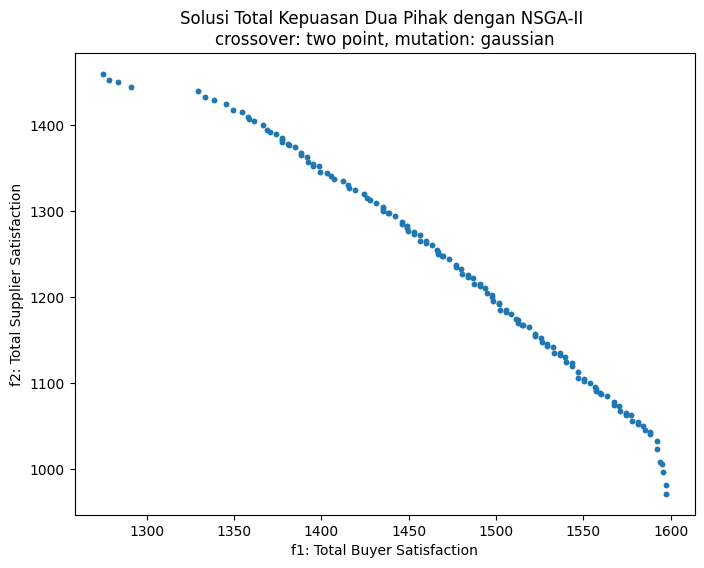

In [17]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(x=-1*F[:,0], y=-1*F[:,1],
            marker='.'
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NSGA-II \ncrossover: two point, mutation: gaussian')
# plt.grid(color='lightgrey')
plt.show()

In [18]:
total_F = np.copy(F)
total_X = np.copy(X)

## second iteration - two point crossover and polynomial mutation

In [19]:
problem = newProblem(total_buyer_sat, total_supplier_sat)
algorithm = NSGA2(pop_size=500,
                  n_offsprings=200,
                  sampling=IntegerRandomSampling(),
                  crossover=TwoPointCrossover(),
                  mutation=PolynomialMutation(),
                  repair=RoundingRepair(),
                  eliminate_duplicates=True,
                )

termination = get_termination("n_gen", 250)
start = time()
res = minimize(problem,
               algorithm,
               # termination,
               seed=7,
               save_history=True,
               verbose=True
              )
print(f"Running time: {time()-start:.4f} seconds")
X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      4 |             - |             -
     2 |      700 |      5 |  0.2415519399 |         ideal
     3 |      900 |      8 |  0.0958529247 |         ideal
     4 |     1100 |      5 |  0.0263072426 |         ideal
     5 |     1300 |      8 |  0.1065002902 |         ideal
     6 |     1500 |      8 |  0.0442584338 |         ideal
     7 |     1700 |      9 |  0.1379133555 |         ideal
     8 |     1900 |     11 |  0.0611997475 |             f
     9 |     2100 |     14 |  0.0804487866 |         ideal
    10 |     2300 |     14 |  0.0811242162 |         ideal
    11 |     2500 |     14 |  0.0328748498 |             f
    12 |     2700 |      9 |  0.1700130378 |         ideal
    13 |     2900 |      5 |  0.1140406477 |         ideal
    14 |     3100 |      8 |  0.0579034557 |         ideal
    15 |     3300 |     10 |  0.0957797015 |         ideal
    16 |     3500 |     13 |  0.0410506162 |            

In [20]:
X[11]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
print(X.shape)
print(F.shape)

(313, 100)
(313, 2)


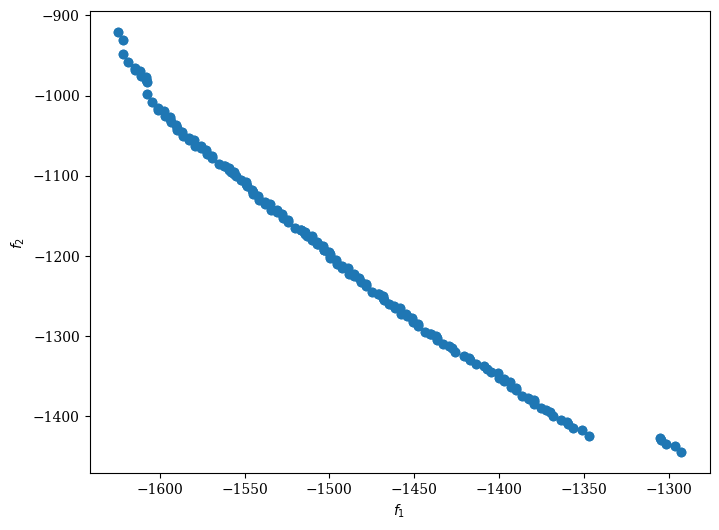

In [22]:
Scatter().add(res.F).show()

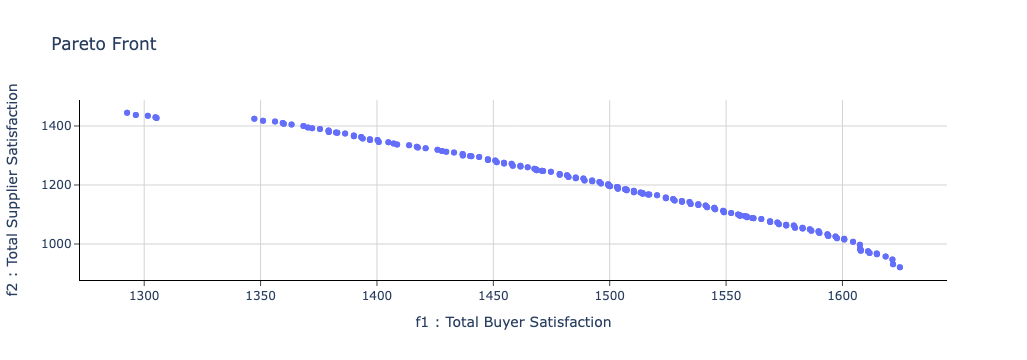

In [23]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*F[:,0], y=-1*F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

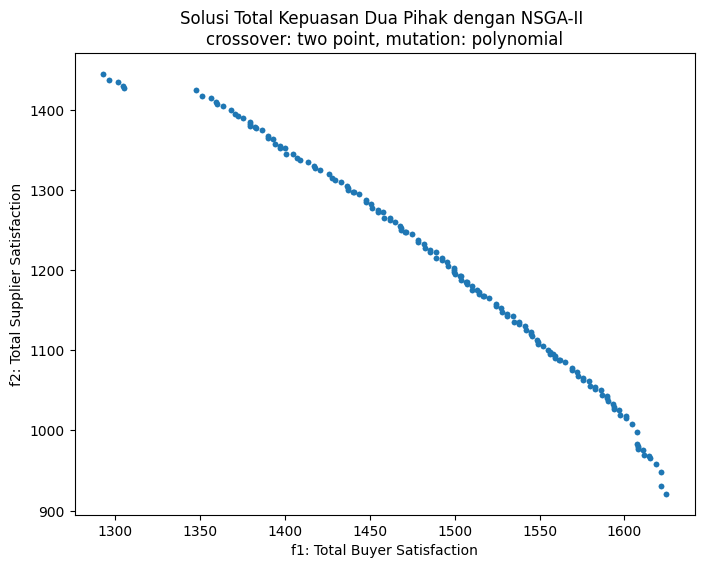

In [24]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(x=-1*F[:,0], y=-1*F[:,1],
            marker='.'
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NSGA-II \ncrossover: two point, mutation: polynomial')
# plt.grid(color='lightgrey')
plt.show()

In [25]:
total_F = np.append(total_F, F, axis=0)
total_X = np.append(total_X, X, axis=0)

# dropping duplicates
total_F, unique_index = np.unique(total_F, axis=0, return_index=True)
# total_X = np.unique(total_X, axis=0)
total_X = total_X[unique_index]

# filter dominated
total_X , total_F = filter_dominated(total_X, total_F)


In [26]:
print(total_X.shape)
print(total_F.shape)

(229, 100)
(229, 2)


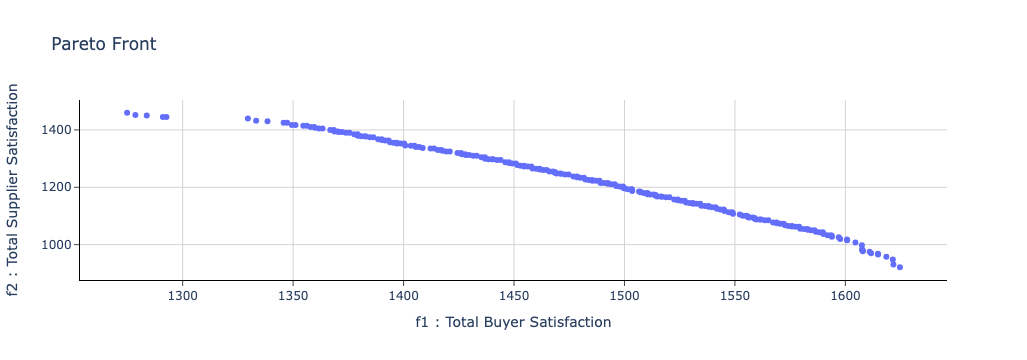

In [27]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*total_F[:,0], y=-1*total_F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

## third iteration - single point crossover and gaussian mutation

In [28]:
problem = newProblem(total_buyer_sat, total_supplier_sat)
algorithm = NSGA2(pop_size=500,
                  n_offsprings=200,
                  sampling=IntegerRandomSampling(),
                  crossover=SinglePointCrossover(),
                  mutation=GaussianMutation(),
                  repair=RoundingRepair(),
                  eliminate_duplicates=True,
                )

# termination = get_termination("n_gen", 200)
start = time()
res = minimize(problem,
               algorithm,
               # termination,
               seed=21,
               save_history=True,
               verbose=True
              )
print(f"Running time: {time()-start:.4f} seconds")

X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      5 |             - |             -
     2 |      700 |      6 |  0.2487292443 |         ideal
     3 |      900 |      9 |  0.1735959405 |         ideal
     4 |     1100 |      7 |  0.0310612597 |         ideal
     5 |     1300 |     10 |  0.0506833713 |         ideal
     6 |     1500 |      8 |  0.1188510942 |         ideal
     7 |     1700 |      9 |  0.1603949309 |         ideal
     8 |     1900 |     11 |  0.0434768756 |             f
     9 |     2100 |      8 |  0.1112536548 |         ideal
    10 |     2300 |      9 |  0.1937400485 |         ideal
    11 |     2500 |      9 |  0.0560143627 |         ideal
    12 |     2700 |      6 |  0.0209869848 |         ideal
    13 |     2900 |     10 |  0.1167313311 |         ideal
    14 |     3100 |     13 |  0.0776962146 |         ideal
    15 |     3300 |     11 |  0.0790221717 |         ideal
    16 |     3500 |     10 |  0.0223605280 |         ide

In [29]:
X[11]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [30]:
print(X.shape)
print(F.shape)

(257, 100)
(257, 2)


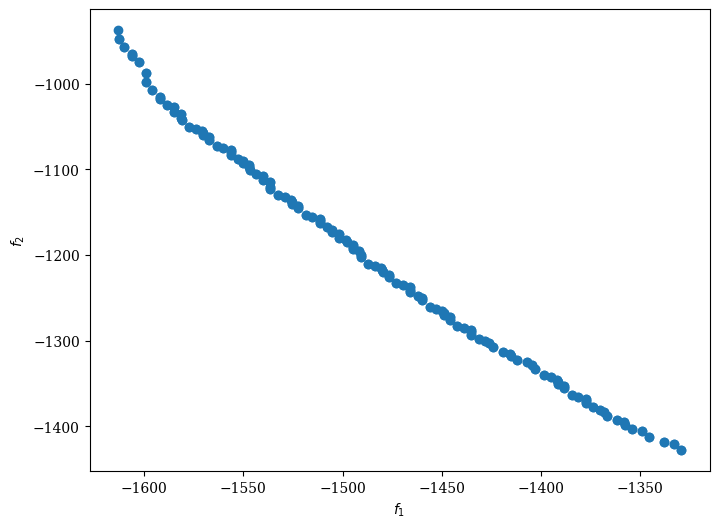

In [31]:
Scatter().add(res.F).show()

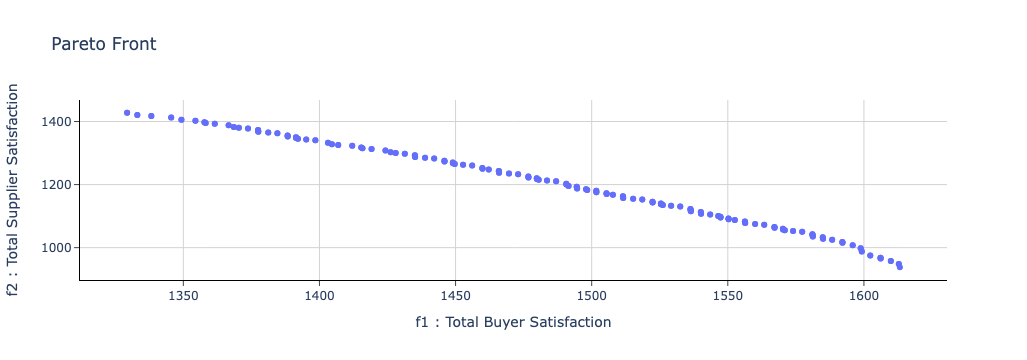

In [32]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*F[:,0], y=-1*F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

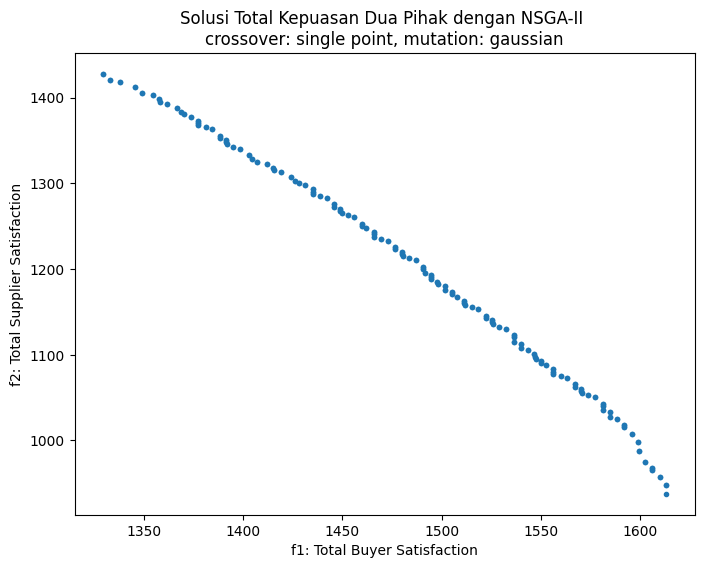

In [33]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(x=-1*F[:,0], y=-1*F[:,1],
            marker='.'
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NSGA-II \ncrossover: single point, mutation: gaussian')
# plt.grid(color='lightgrey')
plt.show()

In [34]:
total_F = np.append(total_F, F, axis=0)
total_X = np.append(total_X, X, axis=0)

# dropping duplicates
total_F, unique_index = np.unique(total_F, axis=0, return_index=True)
# total_X = np.unique(total_X, axis=0)
total_X = total_X[unique_index]

# filter dominated
total_X , total_F = filter_dominated(total_X, total_F)


In [35]:
print(total_X.shape)
print(total_F.shape)

(229, 100)
(229, 2)


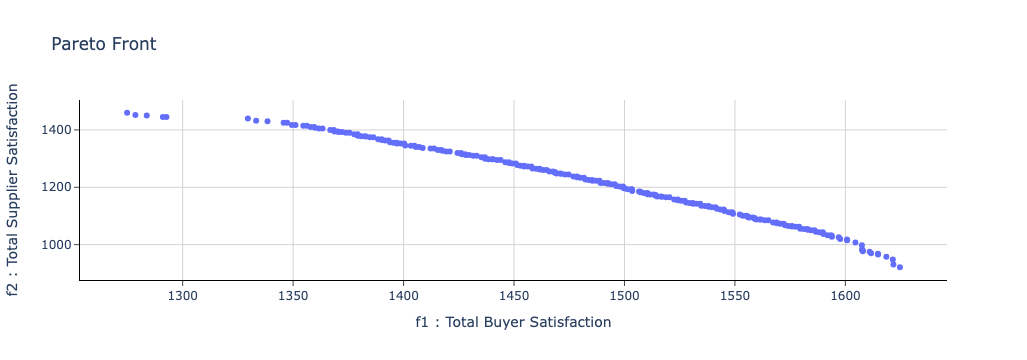

In [36]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*total_F[:,0], y=-1*total_F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

## fourth iteration - single point crossover and polynomial mutation

In [37]:
problem = newProblem(total_buyer_sat, total_supplier_sat)
algorithm = NSGA2(pop_size=500,
                  n_offsprings=200,
                  sampling=IntegerRandomSampling(),
                  crossover=SinglePointCrossover(),
                  mutation=PolynomialMutation(),
                  repair=RoundingRepair(),
                  eliminate_duplicates=True,
                )

# termination = get_termination("n_gen", 200)
start = time()
res = minimize(problem,
               algorithm,
               # termination,
               seed=28,
               save_history=True,
               verbose=True
              )
print(f"Running time: {time()-start:.4f} seconds")
X = res.X
F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      500 |      5 |             - |             -
     2 |      700 |      8 |  0.0197281894 |         ideal
     3 |      900 |     13 |  0.0591773582 |         ideal
     4 |     1100 |      6 |  0.1263362488 |         ideal
     5 |     1300 |      8 |  0.0677333549 |             f
     6 |     1500 |     12 |  0.1337078652 |         ideal
     7 |     1700 |     13 |  0.1350370060 |         ideal
     8 |     1900 |     11 |  0.1136890951 |         ideal
     9 |     2100 |     12 |  0.1540983285 |         ideal
    10 |     2300 |     11 |  0.0207512351 |         ideal
    11 |     2500 |     13 |  0.0536759922 |         ideal
    12 |     2700 |     13 |  0.0642570281 |         ideal
    13 |     2900 |     12 |  0.0341752585 |             f
    14 |     3100 |     17 |  0.0198136078 |         ideal
    15 |     3300 |     17 |  0.0535983138 |         ideal
    16 |     3500 |     17 |  0.0410938604 |         ide

In [38]:
X[11]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [39]:
print(X.shape)
print(F.shape)

(212, 100)
(212, 2)


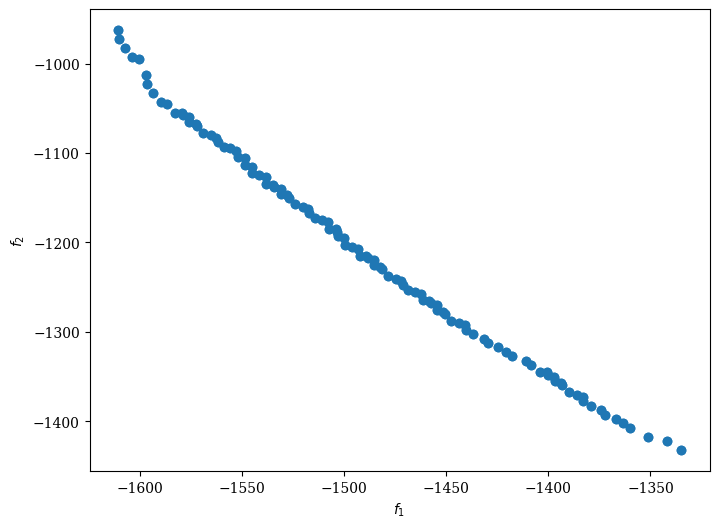

In [40]:
Scatter().add(res.F).show()

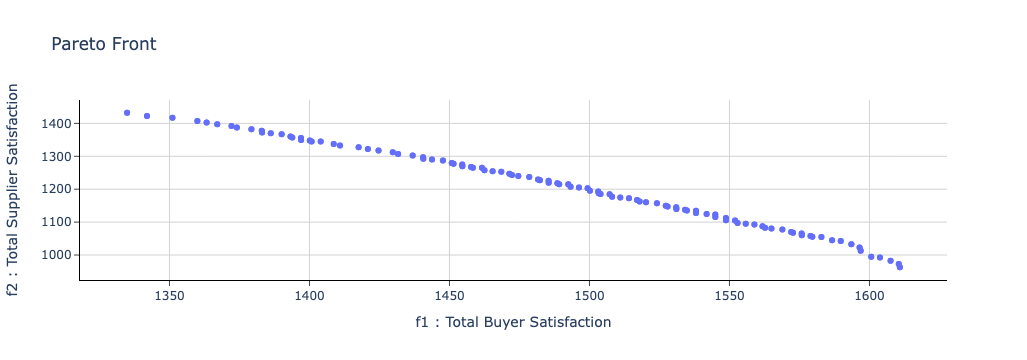

In [41]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*F[:,0], y=-1*F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

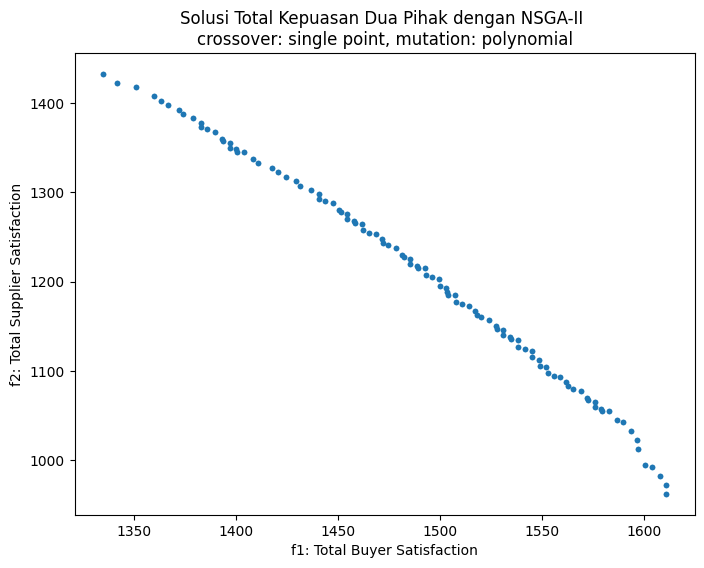

In [42]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(x=-1*F[:,0], y=-1*F[:,1],
            marker='.'
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NSGA-II \ncrossover: single point, mutation: polynomial')
# plt.grid(color='lightgrey')
plt.show()

In [43]:
total_F = np.append(total_F, F, axis=0)
total_X = np.append(total_X, X, axis=0)

# dropping duplicates
total_F, unique_index = np.unique(total_F, axis=0, return_index=True)
# total_X = np.unique(total_X, axis=0)
total_X = total_X[unique_index]

# filter dominated
total_X , total_F = filter_dominated(total_X, total_F)


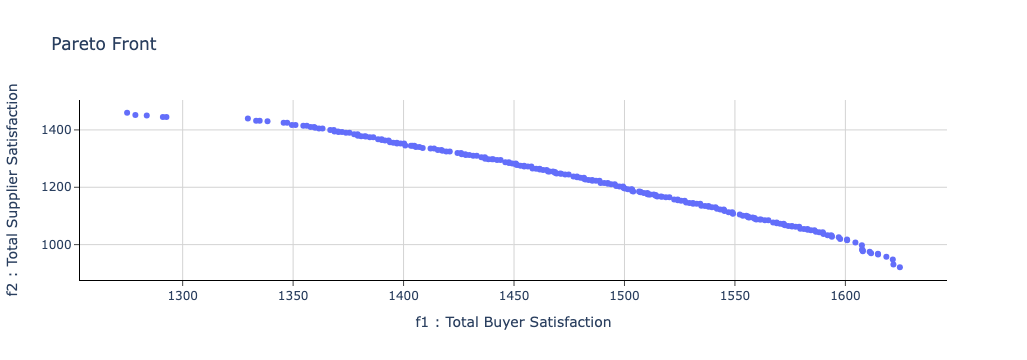

In [44]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=-1*total_F[:,0], y=-1*total_F[:,1], mode='markers'))

fig.update_layout(
    plot_bgcolor='white',
    title='Pareto Front',
    xaxis_title="f1 : Total Buyer Satisfaction",
    yaxis_title="f2 : Total Supplier Satisfaction",
)

fig.update_xaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_yaxes(
#     mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.show()

In [45]:
print(total_X.shape)
print(total_F.shape)

(237, 100)
(237, 2)


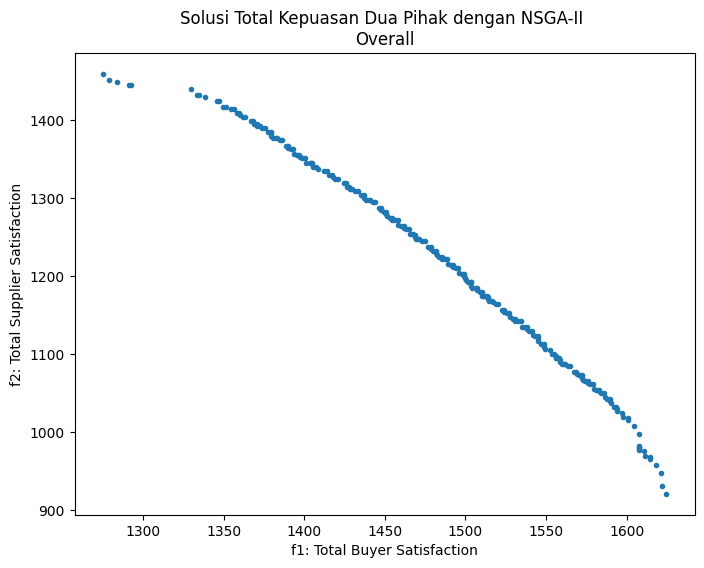

In [46]:
plt.rcdefaults()
plt.figure(figsize=(8,6))
plt.scatter(x=-1*total_F[:,0], y=-1*total_F[:,1],
            marker='.'
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NSGA-II \nOverall')
# plt.grid(color='lightgrey')
plt.show()

In [47]:

X_df = pd.DataFrame(total_X, columns=['x' + str(i) for i in range(1, len(total_X.T)+1)])
F_df = pd.DataFrame(total_F, columns=['f1', 'f2'])

df = pd.concat([F_df, X_df], axis=1)
df.columns =  np.append(np.array(['min', 'min']), ['var' for i in range(len(total_X.T))])
df

min          min  var  var  var  var  var  var  var  var  ...  \
0   -1624.680000  -921.166667    1    1    1    1    1    1    1    1  ...   
1   -1621.746667  -931.166667    1    1    1    1    1    1    1    1  ...   
2   -1621.480000  -947.833333    1    1    1    1    1    1    1    1  ...   
3   -1618.546667  -957.833333    1    1    1    1    1    1    1    1  ...   
4   -1614.796667  -965.333333    1    1    1    1    1    1    1    1  ...   
..           ...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
232 -1292.646667 -1444.833333    1    1    1    1    1    1    1    1  ...   
233 -1291.046667 -1444.833333    1    1    1    1    1    1    1    1  ...   
234 -1283.746667 -1449.833333    1    1    1    1    1    1    1    1  ...   
235 -1278.596667 -1452.333333    1    1    1    1    1    1    1    1  ...   
236 -1274.846667 -1459.833333    1    1    1    1    1    1    1    1  ...   

     var  var  var  var  var  var  var  var  var  var  
0      1    1    1    1    1    1    1    0    1    1  
1      1    1    1    1    1    1    1    0    1    1  
2      1    1    1    1    1    1    1    0    1    1  
3      1    1    1    1    1    1    1    0    1    1  
4      1    1    1    1    1    1    1    1    1    1  
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
232    1    1    1    1    1    1    1    1    1    1  
233    1    1    1    1    1    1    1    1    1    1  
234    1    1    1    1    1    1    1    1    1    1  
235    1    1    1    1    1    1    1    0    1    1  
236    1    1    1    1    1    1    1    1    1    1  

[237 rows x 102 columns]

# Interactive Multiobjective Optimization (IMO)

## first iteration - reference point is not Pareto optimal

In [48]:
from desdeo_mcdm.interactive.NautilusNavigator import NautilusNavigator

In [49]:
F_df

f1           f2
0   -1624.680000  -921.166667
1   -1621.746667  -931.166667
2   -1621.480000  -947.833333
3   -1618.546667  -957.833333
4   -1614.796667  -965.333333
..           ...          ...
232 -1292.646667 -1444.833333
233 -1291.046667 -1444.833333
234 -1283.746667 -1449.833333
235 -1278.596667 -1452.333333
236 -1274.846667 -1459.833333

[237 rows x 2 columns]

In [50]:
front = F_df.to_numpy()
ideal = np.min(front, axis=0)
nadir = np.max(front, axis=0)

In [51]:
print(ideal)
print(nadir)

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]


In [52]:
method = NautilusNavigator((front), ideal, nadir)

In [53]:
req_first = method.start()

print(req_first)
print(req_first.content.keys())

dict_keys(['message', 'ideal', 'nadir', 'reachable_lb', 'reachable_ub', 'user_bounds', 'reachable_idx', 'step_number', 'steps_remaining', 'distance', 'allowed_speeds', 'current_speed', 'navigation_point'])


In [54]:
print(req_first.content["message"])

Please supply aspirations levels for each objective between the upper and lower bounds as `reference_point`. Specify a speed between 1-5 as `speed`. If going to a previous step is desired, please set `go_to_previous` to True, otherwise it should be False. Bounds for one or more objectives may also be specified as 'user_bounds'; when navigating,the value of the objectives present in the navigation points will not exceed the valuesspecified in 'user_bounds'.Lastly, if stopping is desired, `stop` should be True, otherwise it should be set to False.


In [55]:
print(req_first.content["reachable_lb"])
print(req_first.content["reachable_ub"])
print(req_first.content["navigation_point"])

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]
[-1274.84666667  -921.16666667]


In [56]:
reference_point = np.array([-1400, -1200])

response = dict(reference_point=reference_point, go_to_previous=False, stop=False, speed=1, user_bounds=[None, None])
req_first.response = response

In [57]:
previous_requests = [req_first]
step_num_id = [req_first.content['step_number']]
reachable_lb_list = [req_first.content['reachable_lb']]
reachable_ub_list = [req_first.content['reachable_ub']]
navigation_point_list = [req_first.content['navigation_point']]

req = req_first
while method._step_number < 100:
    req.response = response
    req = method.iterate(req)

    previous_requests.append(req)
    step_num_id.append(req.content['step_number'])
    reachable_lb_list.append(req.content['reachable_lb'])
    reachable_ub_list.append(req.content['reachable_ub'])
    navigation_point_list.append(req.content['navigation_point'])

In [58]:
print("steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point")
for step, lb, ub, nav_point in zip(step_num_id, reachable_lb_list, reachable_ub_list, navigation_point_list):
    print(f"{step}     ||  {lb}  ||  {ub}  || {nav_point}")

steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point
1     ||  [-1624.68       -1459.83333333]  ||  [-1274.84666667  -921.16666667]  || [-1274.84666667  -921.16666667]
2     ||  [-1621.74666667 -1452.33333333]  ||  [-1274.84666667  -921.16666667]  || [-1276.60633333  -924.78333333]
3     ||  [-1621.74666667 -1452.33333333]  ||  [-1278.59666667  -931.16666667]  || [-1278.366  -928.4  ]
4     ||  [-1621.48       -1449.83333333]  ||  [-1278.59666667  -931.16666667]  || [-1280.12566667  -932.01666667]
5     ||  [-1621.48       -1449.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1281.88533333  -935.63333333]
6     ||  [-1621.48       -1449.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1283.645  -939.25 ]
7     ||  [-1621.48       -1444.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1285.40466667  -942.86666667]
8     ||  [-1621.48       -1444.83333333]  ||  [-1291.04666667  -947.83333333]  || [-1287.16433333  -946.483333

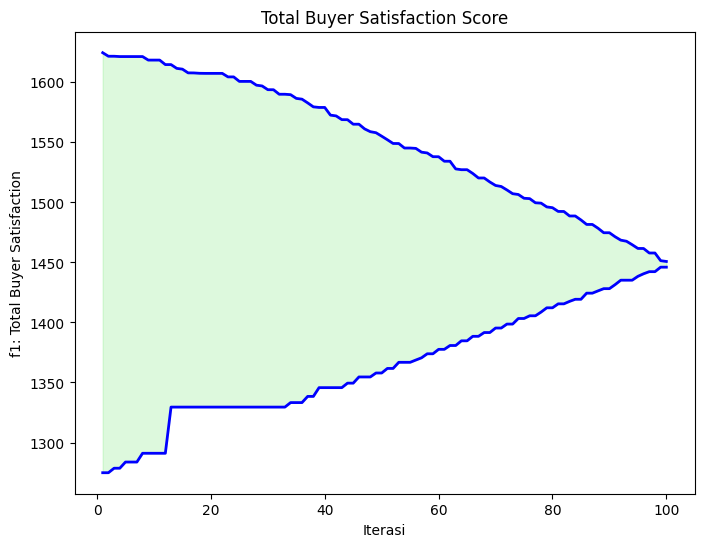

In [59]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 0], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], (-1*np.array(reachable_ub_list)[:, 0]), color='lightgreen', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f1: Total Buyer Satisfaction')
plt.title('Total Buyer Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

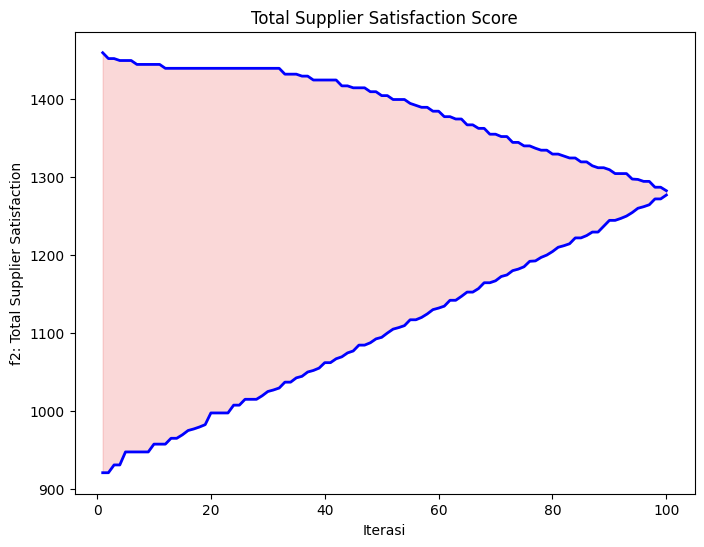

In [60]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 1], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], (-1*np.array(reachable_ub_list)[:, 1]), color='lightcoral', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Total Supplier Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

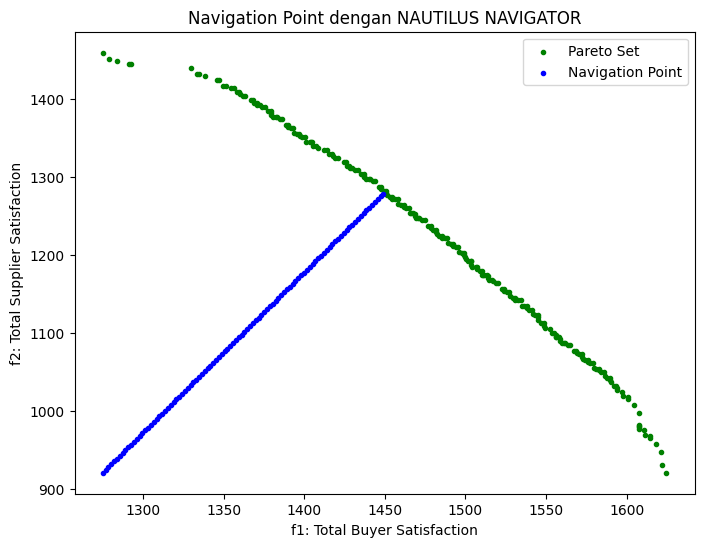

In [61]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*np.array(navigation_point_list)[:,0], y=-1*np.array(navigation_point_list)[:,1], 
            marker='.',
            color='blue',
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Navigation Point dengan NAUTILUS NAVIGATOR')
plt.legend(['Pareto Set', 'Navigation Point'])
# plt.grid(color='lightgrey')
plt.show()

In [62]:
print(req.content["step_number"])
print(req.content["reachable_lb"])
print(req.content["reachable_ub"])
print(req.content["navigation_point"])
print(req.content["reachable_idx"])

100
[-1450.81333333 -1282.83333333]
[-1446.06333333 -1277.33333333]
[-1449.05366667 -1279.21666667]
[152 153 154]


In [63]:
reachable_idx = req.content["reachable_idx"]

display(-1*F_df.iloc[reachable_idx])
display(total_X[reachable_idx].reshape((3,10,10)))

f1           f2
152  1450.813333  1282.833333
153  1450.813333  1279.833333
154  1449.213333  1282.833333

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 

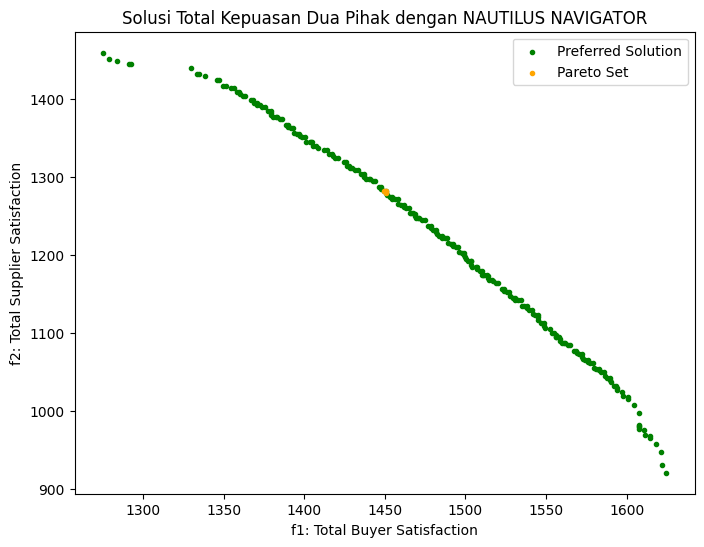

In [64]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='.',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
# plt.grid(color='lightgrey')
plt.show()

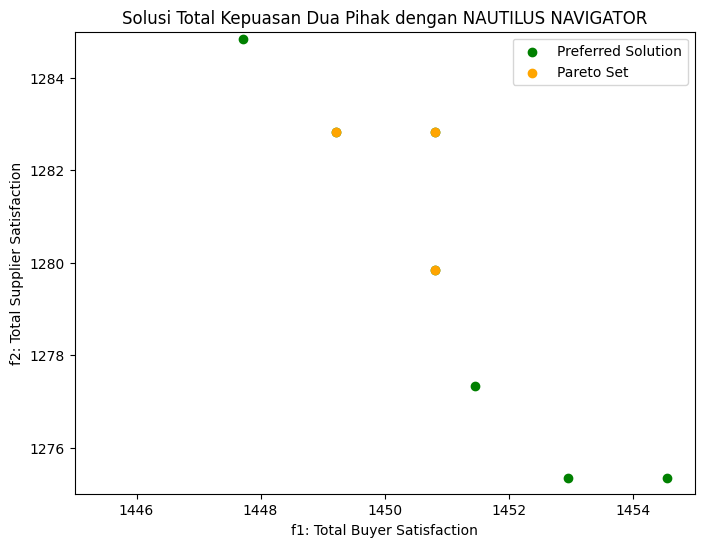

In [65]:
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='o',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='o',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
plt.xlim([1445, 1455])
plt.ylim([1275, 1285])
# plt.grid(color='lightgrey')
plt.show()

## second iteration - reference point outside Pareto front

In [66]:
from desdeo_mcdm.interactive.NautilusNavigator import NautilusNavigator

In [67]:
F_df

f1           f2
0   -1624.680000  -921.166667
1   -1621.746667  -931.166667
2   -1621.480000  -947.833333
3   -1618.546667  -957.833333
4   -1614.796667  -965.333333
..           ...          ...
232 -1292.646667 -1444.833333
233 -1291.046667 -1444.833333
234 -1283.746667 -1449.833333
235 -1278.596667 -1452.333333
236 -1274.846667 -1459.833333

[237 rows x 2 columns]

In [68]:
front = F_df.to_numpy()
ideal = np.min(front, axis=0)
nadir = np.max(front, axis=0)

In [69]:
print(ideal)
print(nadir)

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]


In [70]:
method = NautilusNavigator((front), ideal, nadir)

In [71]:
req_first = method.start()

print(req_first)
print(req_first.content.keys())

dict_keys(['message', 'ideal', 'nadir', 'reachable_lb', 'reachable_ub', 'user_bounds', 'reachable_idx', 'step_number', 'steps_remaining', 'distance', 'allowed_speeds', 'current_speed', 'navigation_point'])


In [72]:
print(req_first.content["message"])

Please supply aspirations levels for each objective between the upper and lower bounds as `reference_point`. Specify a speed between 1-5 as `speed`. If going to a previous step is desired, please set `go_to_previous` to True, otherwise it should be False. Bounds for one or more objectives may also be specified as 'user_bounds'; when navigating,the value of the objectives present in the navigation points will not exceed the valuesspecified in 'user_bounds'.Lastly, if stopping is desired, `stop` should be True, otherwise it should be set to False.


In [73]:
print(req_first.content["reachable_lb"])
print(req_first.content["reachable_ub"])
print(req_first.content["navigation_point"])

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]
[-1274.84666667  -921.16666667]


In [74]:
reference_point = np.array([-1600, -1100])

response = dict(reference_point=reference_point, go_to_previous=False, stop=False, speed=1, user_bounds=[None, None])
req_first.response = response

In [75]:
previous_requests = [req_first]
step_num_id = [req_first.content['step_number']]
reachable_lb_list = [req_first.content['reachable_lb']]
reachable_ub_list = [req_first.content['reachable_ub']]
navigation_point_list = [req_first.content['navigation_point']]

req = req_first
while method._step_number < 100:
    req.response = response
    req = method.iterate(req)

    previous_requests.append(req)
    step_num_id.append(req.content['step_number'])
    reachable_lb_list.append(req.content['reachable_lb'])
    reachable_ub_list.append(req.content['reachable_ub'])
    navigation_point_list.append(req.content['navigation_point'])

In [76]:
print("steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point")
for step, lb, ub, nav_point in zip(step_num_id, reachable_lb_list, reachable_ub_list, navigation_point_list):
    print(f"{step}     ||  {lb}  ||  {ub}  || {nav_point}")

steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point
1     ||  [-1624.68       -1459.83333333]  ||  [-1274.84666667  -921.16666667]  || [-1274.84666667  -921.16666667]
2     ||  [-1621.74666667 -1452.33333333]  ||  [-1274.84666667  -921.16666667]  || [-1277.85666667  -922.58333333]
3     ||  [-1621.74666667 -1449.83333333]  ||  [-1278.59666667  -931.16666667]  || [-1280.86666667  -924.        ]
4     ||  [-1621.74666667 -1444.83333333]  ||  [-1283.74666667  -931.16666667]  || [-1283.87666667  -925.41666667]
5     ||  [-1621.74666667 -1444.83333333]  ||  [-1291.04666667  -931.16666667]  || [-1286.88666667  -926.83333333]
6     ||  [-1621.74666667 -1444.83333333]  ||  [-1291.04666667  -931.16666667]  || [-1289.89666667  -928.25      ]
7     ||  [-1621.74666667 -1439.83333333]  ||  [-1291.04666667  -931.16666667]  || [-1292.90666667  -929.66666667]
8     ||  [-1621.74666667 -1439.83333333]  ||  [-1329.51333333  -931.16666667]  || [-1295.9

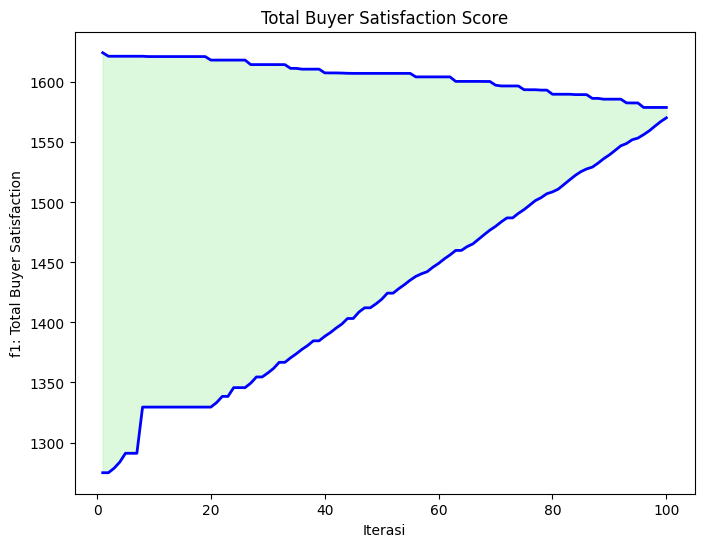

In [77]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 0], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], (-1*np.array(reachable_ub_list)[:, 0]), color='lightgreen', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f1: Total Buyer Satisfaction')
plt.title('Total Buyer Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

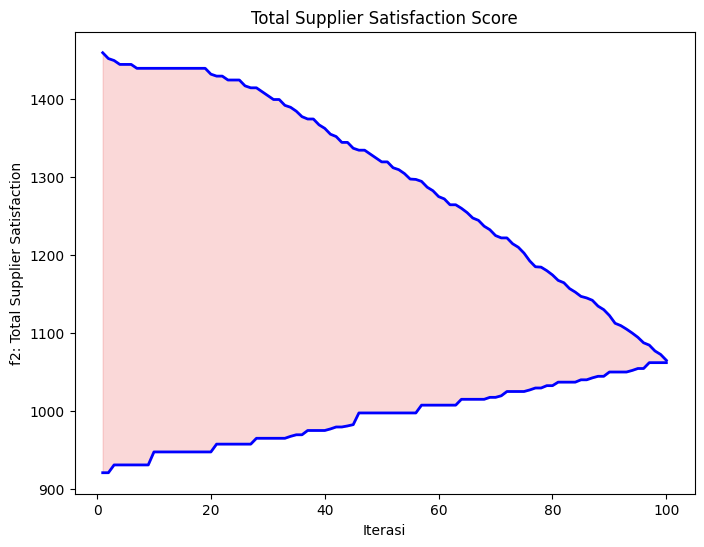

In [78]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 1], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], (-1*np.array(reachable_ub_list)[:, 1]), color='lightcoral', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Total Supplier Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

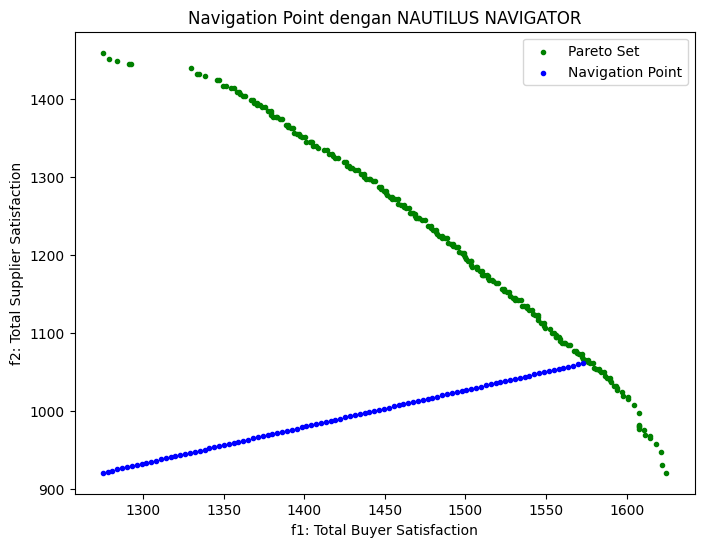

In [79]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*np.array(navigation_point_list)[:,0], y=-1*np.array(navigation_point_list)[:,1], 
            marker='.',
            color='blue',
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Navigation Point dengan NAUTILUS NAVIGATOR')
plt.legend(['Pareto Set', 'Navigation Point'])
# plt.grid(color='lightgrey')
plt.show()

In [80]:
print(req.content["step_number"])
print(req.content["reachable_lb"])
print(req.content["reachable_ub"])
print(req.content["navigation_point"])
print(req.content["reachable_idx"])

100
[-1579.09666667 -1065.33333333]
[-1570.44666667 -1062.33333333]
[-1572.83666667 -1061.41666667]
[33 34 35 36 37]


In [81]:
reachable_idx = req.content["reachable_idx"]

display(-1*F_df.iloc[reachable_idx])
display(total_X[reachable_idx].reshape((5,10,10)))

f1           f2
33  1579.096667  1062.333333
34  1577.496667  1062.333333
35  1575.846667  1062.833333
36  1575.796667  1065.333333
37  1574.196667  1065.333333

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 

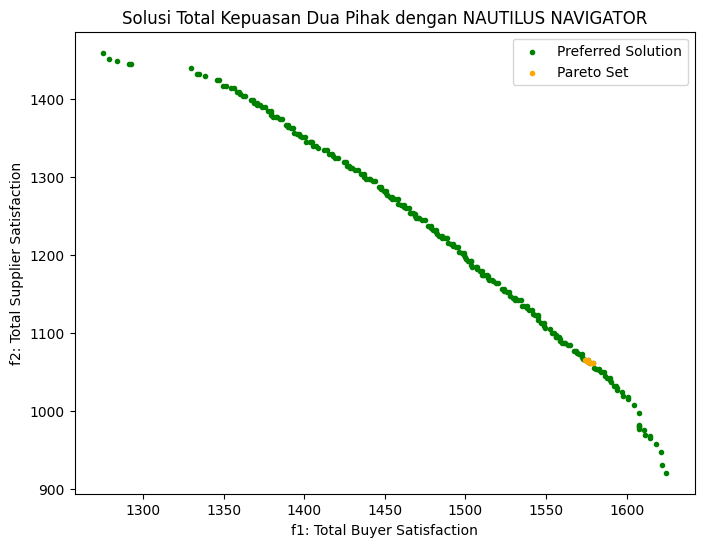

In [82]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='.',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
# plt.grid(color='lightgrey')
plt.show()

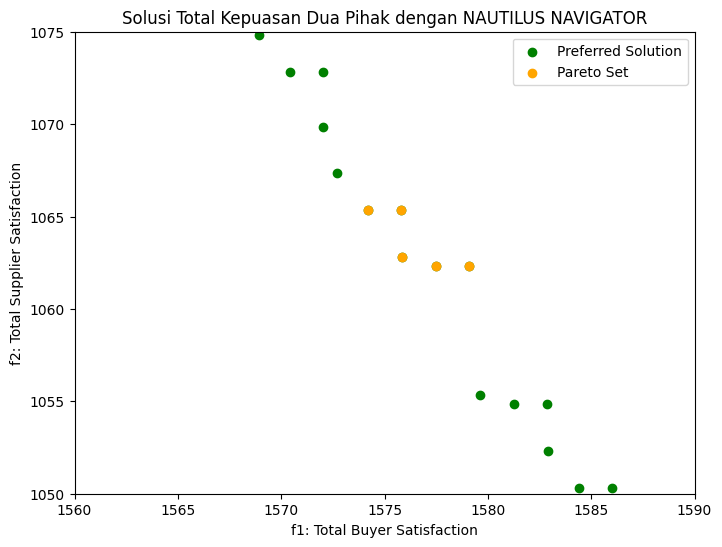

In [83]:
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='o',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='o',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
plt.xlim([1560, 1590])
plt.ylim([1050, 1075])
# plt.grid(color='lightgrey')
plt.show()

## third iteration - changing reference point 

In [84]:
from desdeo_mcdm.interactive.NautilusNavigator import NautilusNavigator

In [85]:
F_df

f1           f2
0   -1624.680000  -921.166667
1   -1621.746667  -931.166667
2   -1621.480000  -947.833333
3   -1618.546667  -957.833333
4   -1614.796667  -965.333333
..           ...          ...
232 -1292.646667 -1444.833333
233 -1291.046667 -1444.833333
234 -1283.746667 -1449.833333
235 -1278.596667 -1452.333333
236 -1274.846667 -1459.833333

[237 rows x 2 columns]

In [86]:
front = F_df.to_numpy()
ideal = np.min(front, axis=0)
nadir = np.max(front, axis=0)

In [87]:
print(ideal)
print(nadir)

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]


In [88]:
method = NautilusNavigator((front), ideal, nadir)

In [89]:
req_first = method.start()

print(req_first)
print(req_first.content.keys())

dict_keys(['message', 'ideal', 'nadir', 'reachable_lb', 'reachable_ub', 'user_bounds', 'reachable_idx', 'step_number', 'steps_remaining', 'distance', 'allowed_speeds', 'current_speed', 'navigation_point'])


In [90]:
print(req_first.content["message"])

Please supply aspirations levels for each objective between the upper and lower bounds as `reference_point`. Specify a speed between 1-5 as `speed`. If going to a previous step is desired, please set `go_to_previous` to True, otherwise it should be False. Bounds for one or more objectives may also be specified as 'user_bounds'; when navigating,the value of the objectives present in the navigation points will not exceed the valuesspecified in 'user_bounds'.Lastly, if stopping is desired, `stop` should be True, otherwise it should be set to False.


In [91]:
print(req_first.content["reachable_lb"])
print(req_first.content["reachable_ub"])
print(req_first.content["navigation_point"])

[-1624.68       -1459.83333333]
[-1274.84666667  -921.16666667]
[-1274.84666667  -921.16666667]


In [92]:
reference_point = np.array([-1400, -1200])

response = dict(reference_point=reference_point, go_to_previous=False, stop=False, speed=1, user_bounds=[None, None])
req_first.response = response

In [93]:
previous_requests = [req_first]
step_num_id = [req_first.content['step_number']]
reachable_lb_list = [req_first.content['reachable_lb']]
reachable_ub_list = [req_first.content['reachable_ub']]
navigation_point_list = [req_first.content['navigation_point']]

req = req_first
while method._step_number < 100:
    req.response = response
    req = method.iterate(req)

    previous_requests.append(req)
    step_num_id.append(req.content['step_number'])
    reachable_lb_list.append(req.content['reachable_lb'])
    reachable_ub_list.append(req.content['reachable_ub'])
    navigation_point_list.append(req.content['navigation_point'])

In [94]:
print("steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point")
for step, lb, ub, nav_point in zip(step_num_id, reachable_lb_list, reachable_ub_list, navigation_point_list):
    print(f"{step}     ||  {lb}  ||  {ub}  || {nav_point}")

steps ||           reachable_lb          ||          reachable_ub           ||         navigation_point
1     ||  [-1624.68       -1459.83333333]  ||  [-1274.84666667  -921.16666667]  || [-1274.84666667  -921.16666667]
2     ||  [-1621.74666667 -1452.33333333]  ||  [-1274.84666667  -921.16666667]  || [-1276.60633333  -924.78333333]
3     ||  [-1621.74666667 -1452.33333333]  ||  [-1278.59666667  -931.16666667]  || [-1278.366  -928.4  ]
4     ||  [-1621.48       -1449.83333333]  ||  [-1278.59666667  -931.16666667]  || [-1280.12566667  -932.01666667]
5     ||  [-1621.48       -1449.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1281.88533333  -935.63333333]
6     ||  [-1621.48       -1449.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1283.645  -939.25 ]
7     ||  [-1621.48       -1444.83333333]  ||  [-1283.74666667  -947.83333333]  || [-1285.40466667  -942.86666667]
8     ||  [-1621.48       -1444.83333333]  ||  [-1291.04666667  -947.83333333]  || [-1287.16433333  -946.483333

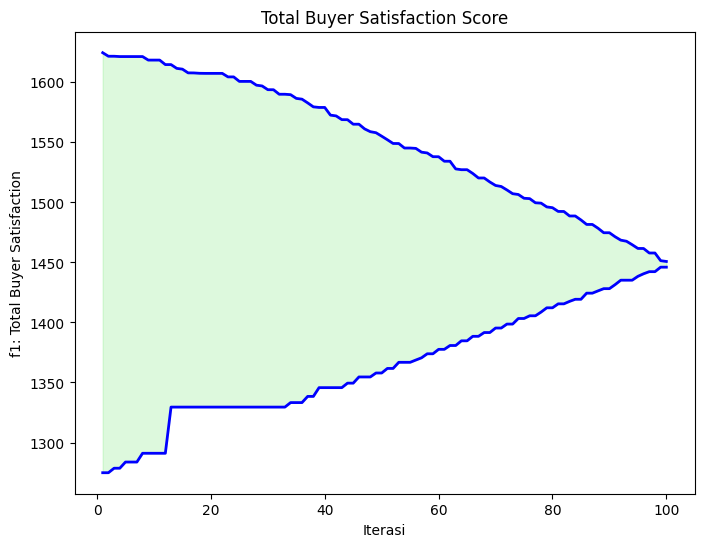

In [95]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 0], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 0], (-1*np.array(reachable_ub_list)[:, 0]), color='lightgreen', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f1: Total Buyer Satisfaction')
plt.title('Total Buyer Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

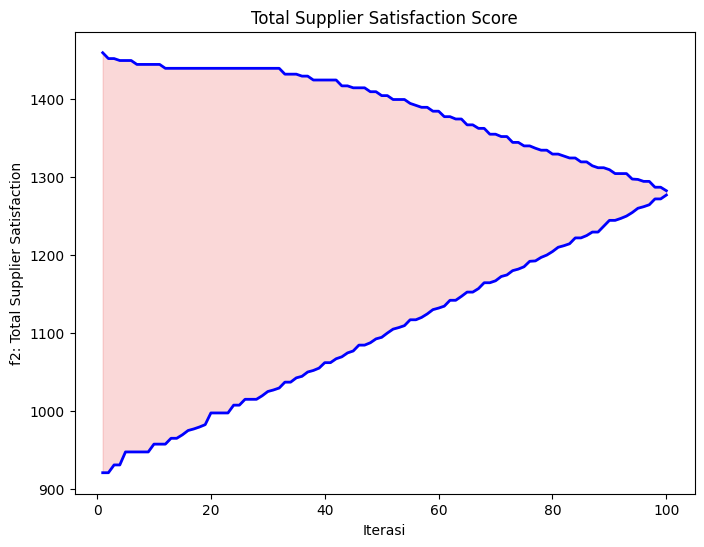

In [96]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id), -1*np.array(reachable_ub_list)[:, 1], color='blue', lw=2)
plt.plot(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], color='blue', lw=2)
plt.fill_between(np.array(step_num_id), -1*np.array(reachable_lb_list)[:, 1], (-1*np.array(reachable_ub_list)[:, 1]), color='lightcoral', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Total Supplier Satisfaction Score')
# plt.grid(color='lightgrey')
plt.show()

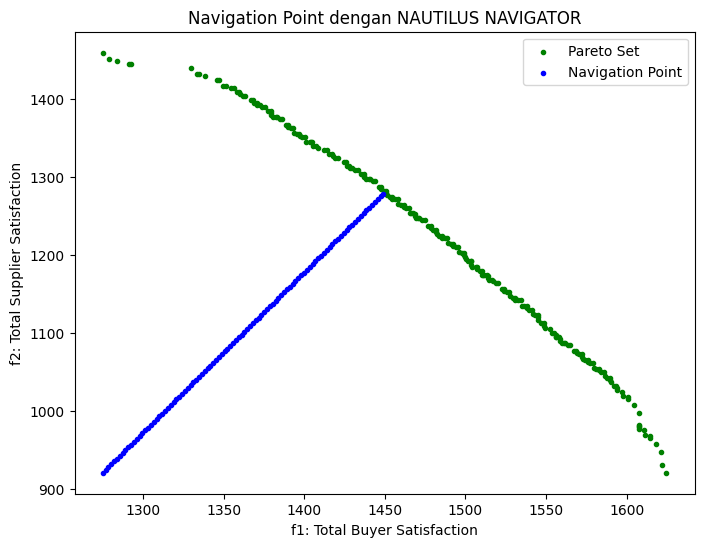

In [97]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*np.array(navigation_point_list)[:,0], y=-1*np.array(navigation_point_list)[:,1], 
            marker='.',
            color='blue',
           )

plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Navigation Point dengan NAUTILUS NAVIGATOR')
plt.legend(['Pareto Set', 'Navigation Point'])
# plt.grid(color='lightgrey')
plt.show()

In [98]:
print(req.content["step_number"])
print(req.content["reachable_lb"])
print(req.content["reachable_ub"])

print(req.content["navigation_point"])
print(req.content["reachable_idx"])

100
[-1450.81333333 -1282.83333333]
[-1446.06333333 -1277.33333333]
[-1449.05366667 -1279.21666667]
[152 153 154]


In [99]:
F_df.iloc[[152, 153, 154]]

f1           f2
152 -1450.813333 -1282.833333
153 -1450.813333 -1279.833333
154 -1449.213333 -1282.833333

In [100]:
# fetch the 55th step saved previously
req_xx = previous_requests[77]
print(req_xx.content["reachable_lb"])
print(req_xx.content["reachable_ub"])
print(req_xx.content["step_number"])
print(req_xx.content["navigation_point"])


[-1499.39666667 -1334.83333333]
[-1408.66333333 -1197.33333333]
78
[-1410.341 -1199.65 ]


In [101]:
req_xx.response["go_to_previous"] = True
req_xx.response["reference_point"] = np.array([-1500, -1200])
new_response = req_xx.response

req_xx_new = method.iterate(req_xx)

new_previous_requests = [req_xx_new]
new_step_num_id = [req_xx_new.content['step_number']]
new_reachable_lb_list = [req_xx_new.content['reachable_lb']]
new_reachable_ub_list = [req_xx_new.content['reachable_ub']]
new_navigation_point_list = [req_xx_new.content['navigation_point']]

req = req_xx_new

# remember to unser go_to_previous!
new_response["go_to_previous"] = False

# continue iterating for remaining steps
while method._step_number < 100:
    req.response = new_response
    req = method.iterate(req)

    new_previous_requests.append(req)
    new_step_num_id.append(req.content['step_number'])
    new_reachable_lb_list.append(req.content['reachable_lb'])
    new_reachable_ub_list.append(req.content['reachable_ub'])
    new_navigation_point_list.append(req.content['navigation_point'])

In [102]:
print("steps ||            reachable_lb            ||            reachable_ub           ||         navigation_point")
for step, lb, ub, nav_point in zip(new_step_num_id, new_reachable_lb_list, new_reachable_ub_list, new_navigation_point_list):
    print(f"{step}     ||  {lb}  ||  {ub}  || {nav_point}")

steps ||            reachable_lb            ||            reachable_ub           ||         navigation_point
78     ||  [-1499.39666667 -1334.83333333]  ||  [-1408.66333333 -1197.33333333]  || [-1410.341 -1199.65 ]
79     ||  [-1499.39666667 -1329.83333333]  ||  [-1412.21333333 -1200.33333333]  || [-1414.21298551 -1199.67971014]
80     ||  [-1499.39666667 -1324.83333333]  ||  [-1415.51333333 -1200.33333333]  || [-1418.08497101 -1199.70942029]
81     ||  [-1499.39666667 -1319.83333333]  ||  [-1419.31333333 -1200.33333333]  || [-1421.95695652 -1199.73913043]
82     ||  [-1499.39666667 -1319.83333333]  ||  [-1424.41333333 -1200.33333333]  || [-1425.82894203 -1199.76884058]
83     ||  [-1499.39666667 -1312.33333333]  ||  [-1424.41333333 -1200.33333333]  || [-1429.70092754 -1199.79855072]
84     ||  [-1499.39666667 -1304.83333333]  ||  [-1428.16333333 -1200.33333333]  || [-1433.57291304 -1199.82826087]
85     ||  [-1499.39666667 -1297.83333333]  ||  [-1435.21333333 -1200.33333333]  || [-143

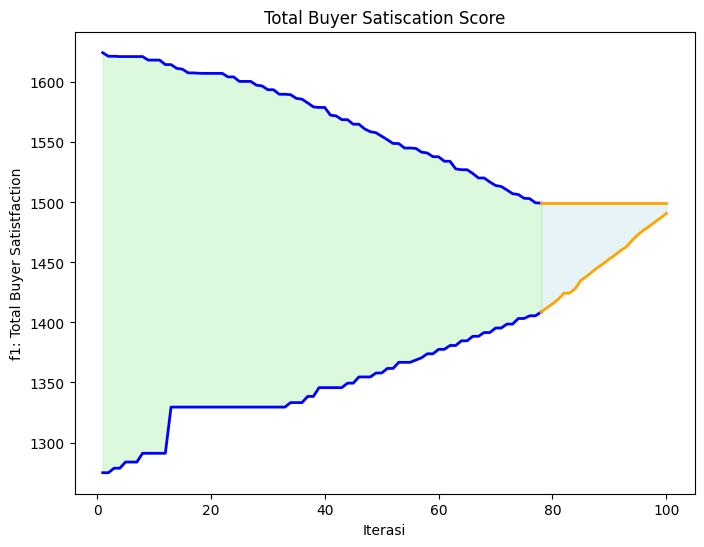

In [103]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id[:78]), -1*np.array(reachable_ub_list)[:78, 0], color='blue', lw=2)
plt.plot(np.array(step_num_id[:78]), -1*np.array(reachable_lb_list)[:78, 0], color='blue', lw=2)
plt.plot(np.array(new_step_num_id), -1*np.array(new_reachable_ub_list)[:, 0], color='orange', lw=2)
plt.plot(np.array(new_step_num_id), -1*np.array(new_reachable_lb_list)[:, 0], color='orange', lw=2)
plt.fill_between(np.array(step_num_id[:78]), -1*np.array(reachable_lb_list)[:78, 0], (-1*np.array(reachable_ub_list)[:78, 0]), color='lightgreen', alpha=0.3)
plt.fill_between(np.array(new_step_num_id), -1*np.array(new_reachable_lb_list)[:, 0], (-1*np.array(new_reachable_ub_list)[:, 0]), color='lightblue', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f1: Total Buyer Satistfaction')
plt.title('Total Buyer Satiscation Score')
# plt.grid(color='lightgrey')
plt.show()

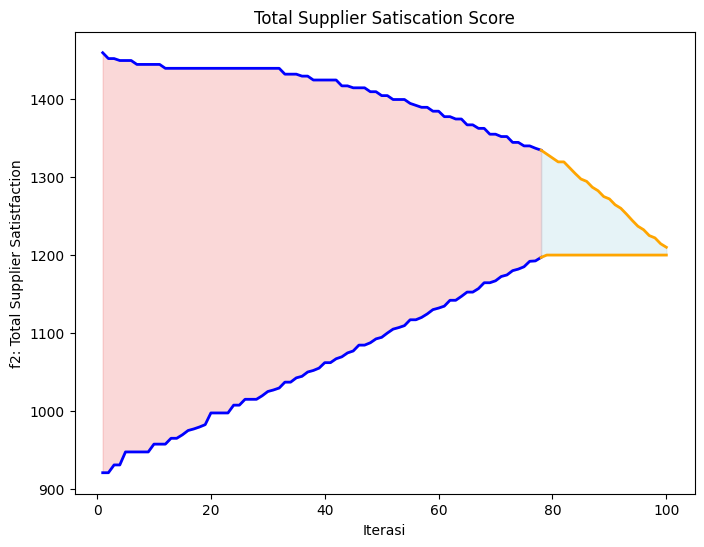

In [104]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.plot(np.array(step_num_id[:78]), -1*np.array(reachable_ub_list)[:78, 1], color='blue', lw=2)
plt.plot(np.array(step_num_id[:78]), -1*np.array(reachable_lb_list)[:78, 1], color='blue', lw=2)
plt.plot(np.array(new_step_num_id), -1*np.array(new_reachable_ub_list)[:, 1], color='orange', lw=2)
plt.plot(np.array(new_step_num_id), -1*np.array(new_reachable_lb_list)[:, 1], color='orange', lw=2)
plt.fill_between(np.array(step_num_id[:78]), -1*np.array(reachable_lb_list)[:78, 1], (-1*np.array(reachable_ub_list)[:78, 1]), color='lightcoral', alpha=0.3)
plt.fill_between(np.array(new_step_num_id), -1*np.array(new_reachable_lb_list)[:, 1], (-1*np.array(new_reachable_ub_list)[:, 1]), color='lightblue', alpha=0.3)

plt.xlabel('Iterasi')
plt.ylabel('f2: Total Supplier Satistfaction')
plt.title('Total Supplier Satiscation Score')
# plt.grid(color='lightgrey')
plt.show()

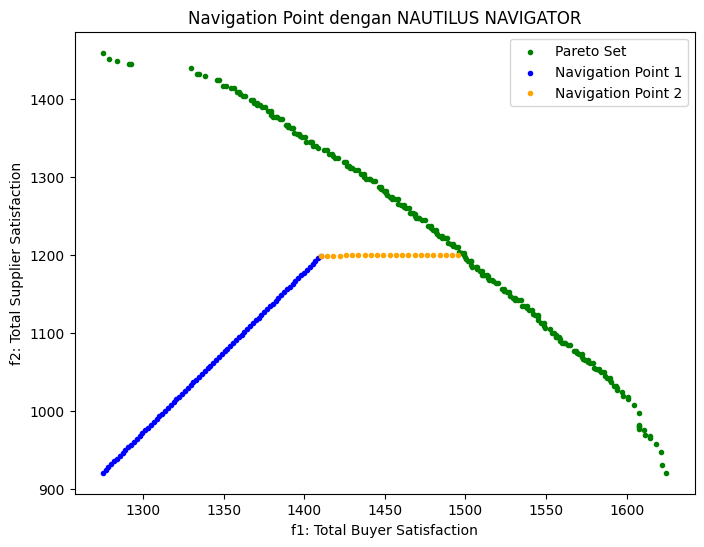

In [105]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*np.array(navigation_point_list)[:78,0], y=-1*np.array(navigation_point_list)[:78,1], 
            marker='.',
            color='blue',
           )

plt.scatter(x=-1*np.array(new_navigation_point_list)[:,0], y=-1*np.array(new_navigation_point_list)[:,1], 
            marker='.',
            color='orange',
           )



plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Navigation Point dengan NAUTILUS NAVIGATOR')
plt.legend(['Pareto Set', 'Navigation Point 1', 'Navigation Point 2'])
# plt.grid(color='lightgrey')
plt.show()

In [106]:
print(req.content["step_number"])
print(req.content["reachable_lb"])
print(req.content["reachable_ub"])
print(req.content["navigation_point"])
print(req.content["reachable_idx"])

100
[-1499.39666667 -1210.33333333]
[-1490.84666667 -1200.33333333]
[-1495.52468116 -1200.30362319]
[108 109 110 111 112 113]


In [107]:
reachable_idx = req.content["reachable_idx"]

display(-1*F_df.iloc[reachable_idx])
display(total_X[reachable_idx].reshape((6,10,10)))

f1           f2
108  1499.396667  1200.333333
109  1499.346667  1202.833333
110  1497.746667  1202.833333
111  1496.246667  1204.833333
112  1495.596667  1210.333333
113  1493.996667  1210.333333

array([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1]],

       [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 

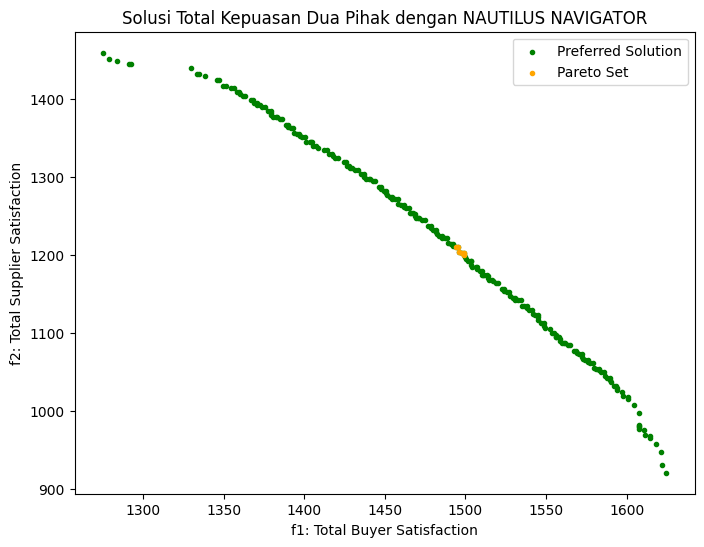

In [108]:
plt.rcdefaults()
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='.',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='.',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
# plt.grid(color='lightgrey')
plt.show()

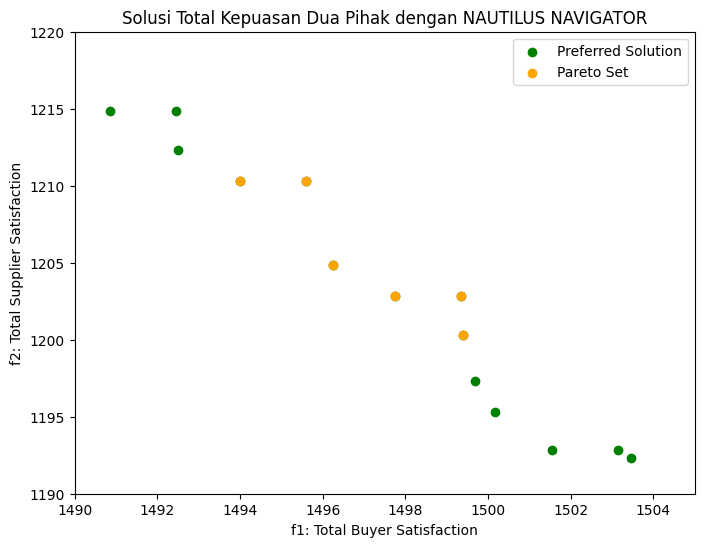

In [109]:
plt.figure(figsize=(8,6))

plt.scatter(x=-1*F_df['f1'], y=-1*F_df['f2'], 
            marker='o',
            color='green',
           )

plt.scatter(x=-1*F_df.loc[reachable_idx, 'f1'], y=-1*F_df.loc[reachable_idx, 'f2'], 
            marker='o',
            color='orange',
           )


plt.xlabel('f1: Total Buyer Satisfaction')
plt.ylabel('f2: Total Supplier Satisfaction')
plt.title('Solusi Total Kepuasan Dua Pihak dengan NAUTILUS NAVIGATOR')
plt.legend(['Preferred Solution', 'Pareto Set'])
plt.xlim([1490, 1505])
plt.ylim([1190, 1220])
# plt.grid(color='lightgrey')
plt.show()